# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import lightgbm as lgb
import catboost
from tqdm.notebook import tqdm


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error
from time import time

import warnings
warnings.filterwarnings("ignore")


try:
    import phik
except:
    !pip install phik -q

    
import phik 
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
try:
    auto = pd.read_csv('/datasets/autos.csv')
except:
    auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
display(auto.head())
auto['DateCreated'].max()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'2016-04-07 00:00:00'

Мы видим, что не все признаки важны для нашего исследования, определим какие влияют на цену и оставим их:

1. Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова - ВАЖЕН
- RegistrationYear — год регистрации автомобиля - ВАЖЕН
- Gearbox — тип коробки передач - ВАЖЕН
- Power — мощность (л. с.) - ВАЖЕН
- Model — модель автомобиля - ВАЖЕН
- Kilometer — пробег (км) - ВАЖЕН
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива - ВАЖЕН
- Brand — марка автомобиля - ВАЖЕН
- Repaired — была машина в ремонте или нет -ВАЖЕН
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

Оставим необходимые признаки:

In [5]:
auto_df = auto[['VehicleType', 'RegistrationYear','Gearbox', 'Power','Model', 'Kilometer','FuelType','Brand','Repaired','Price']]

Переведем все в змеинный стиль:

In [6]:
auto_df.columns = auto_df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
auto_df.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired', 'price'],
      dtype='object')

In [7]:
def descr (df):
    display(df.head(5))
    print('---------------------------------------------------------------------------------------------------------')
    display(df.info()) 
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество пропусков:  {df.isna().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Размер: {df.shape}')
    print('---------------------------------------------------------------------------------------------------------')
    print(df.describe())

In [8]:
descr(auto_df)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price
0,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,480
1,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,18300
2,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,9800
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       316879 non-null  object
 1   registration_year  354369 non-null  int64 
 2   gearbox            334536 non-null  object
 3   power              354369 non-null  int64 
 4   model              334664 non-null  object
 5   kilometer          354369 non-null  int64 
 6   fuel_type          321474 non-null  object
 7   brand              354369 non-null  object
 8   repaired           283215 non-null  object
 9   price              354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 45040
---------------------------------------------------------------------------------------------------------
Количество пропусков:  vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
price                    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Размер: (354369, 10)
---------------------------------------------------------------------------------------------------------
       registration_year          power      kilometer          price
count      354369.000000  354369.000000  354369.000000  354369.000000
mean         2004.234448     110.094337  128211.172535    4416.656776
std       

После загрузки данных, оставили только признаки которые влияют на цену. Видим что в колонках Gearbox, Model, FuelType, Repaired 
есть пропущенные значение, а также большое количество дубликатов. Также строки с ценной ноль, можно удалить и те где год выпуска стоит 1000.

Удалим дубликаты

In [9]:
#auto_df = auto_df.drop_duplicates()
#auto_df.duplicated().sum()

Рассмотрим данные на пропущенные значения

In [10]:
print(auto_df.isna().sum())
pd.DataFrame(round(auto_df.isna().mean()*100,1)).style.background_gradient('coolwarm')

vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
price                    0
dtype: int64


,0
vehicle_type,10.600000
registration_year,0.000000
gearbox,5.600000
power,0.000000
model,5.600000
kilometer,0.000000
fuel_type,9.300000
brand,0.000000
repaired,20.100000
price,0.000000


Мы видим , что цифры выглядившими большими в количественном отношении в процентном выглядят не так страшно.
Изучим колонки где есть пропущенные значения чтобы решить что с ними делать.

In [11]:
display(auto_df['vehicle_type']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'vehicle_type':'count', 'index':'vehicle_type'}))

,vehicle_type,count
0,sedan,91457
1,small,79831
2,wagon,65166
3,NaN,37490
4,bus,28775
5,convertible,20203
6,coupe,16163
7,suv,11996
8,other,3288


В данном случае заменим Nan на unknown

In [12]:
auto_df.fillna({'vehicle_type':'no_info'}, inplace=True)

In [13]:
display(auto_df['gearbox']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'gearbox':'count', 'index':'gearbox'}))

,gearbox,count
0,manual,268251
1,auto,66285
2,NaN,19833


In [14]:
auto_df.fillna({'gearbox':'no_info'}, inplace=True)

In [15]:
display(auto_df['model']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'model':'count', 'index':'model'}))

,model,count
0,golf,29232
1,other,24421
2,3er,19761
3,NaN,19705
4,polo,13066
...,...,...
246,i3,8
247,serie_3,4
248,rangerover,4
249,range_rover_evoque,2


In [16]:
auto_df.fillna({'model':'no_info'}, inplace=True)

In [17]:
display(auto_df['fuel_type']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'fuel_type':'count', 'index':'fuel_type'}))

,fuel_type,count
0,petrol,216352
1,gasoline,98720
2,NaN,32895
3,lpg,5310
4,cng,565
5,hybrid,233
6,other,204
7,electric,90


In [18]:
auto_df.fillna({'fuel_type':'no_info'}, inplace=True)

In [19]:
display(auto_df['repaired']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'repaired':'count', 'index':'repaired'}))

,repaired,count
0,no,247161
1,NaN,71154
2,yes,36054


Учитывая что большинство поддержаных авто не было в авариях здесь пропуски решили присоединить к категории "no"

In [20]:
auto_df.fillna({'repaired':'no'}, inplace=True)

Изучим целевой признак 'price'

In [21]:
def hist_box(df,col):
    fig, axs = plt.subplots(ncols=2,figsize=(16,8))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0], color='green').set_title(f'Распределение {col}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'Ящик с усами {col}',fontsize=20); 
    
    print(df[col].describe()) 

Оставим данные где цена выше ноля:

In [22]:
print("Колличество объявлений с нулевой ценой:",len(auto_df.loc[auto_df['price'] == 0]))

Колличество объявлений с нулевой ценой: 10772


In [23]:
auto_df.price.quantile([0.05, 1])

0.05      200.0
1.00    20000.0
Name: price, dtype: float64

In [24]:
auto_df = auto_df.query('price > 1000')

count    266394.000000
mean       5699.998416
std        4520.785920
min        1001.000000
25%        2200.000000
50%        4000.000000
75%        7950.000000
max       20000.000000
Name: price, dtype: float64


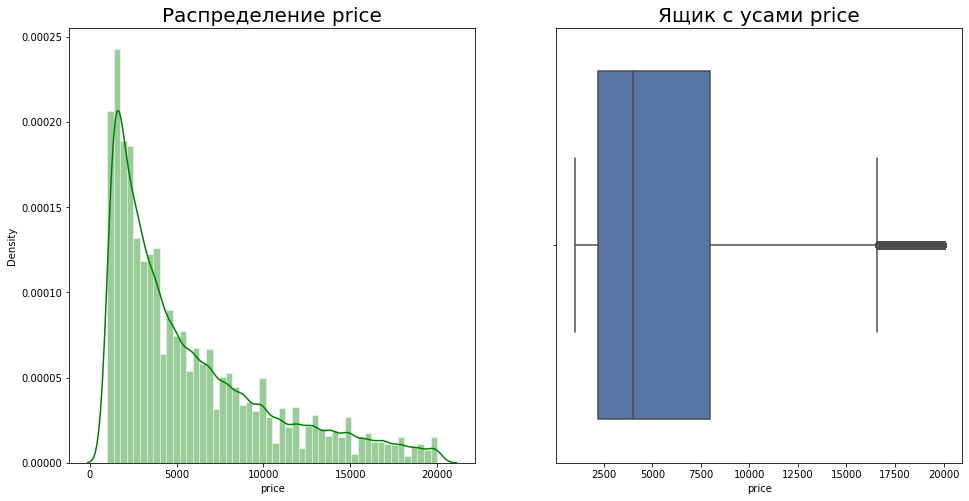

In [25]:
hist_box(auto_df, 'price')

Изучив признак 'price' мы видим, что количество объявлений с нулевой ценой: 8904, мы их удалили так как это явная ошибка к тому же в общем количестве их число незначительно. Также рассчитали 0,05 квантиль.

Теперь исследуем признак registration_year.

Мы видим что минимальные значения это 1000 год а максимальные 9999 год. Логично будет начать с 1910 года(год появления авто) и до 2024 года. 

In [26]:
auto_df = auto_df.query('registration_year >= 1910 and registration_year <= 2024')

count    266337.000000
mean       2004.220277
std           7.050024
min        1910.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


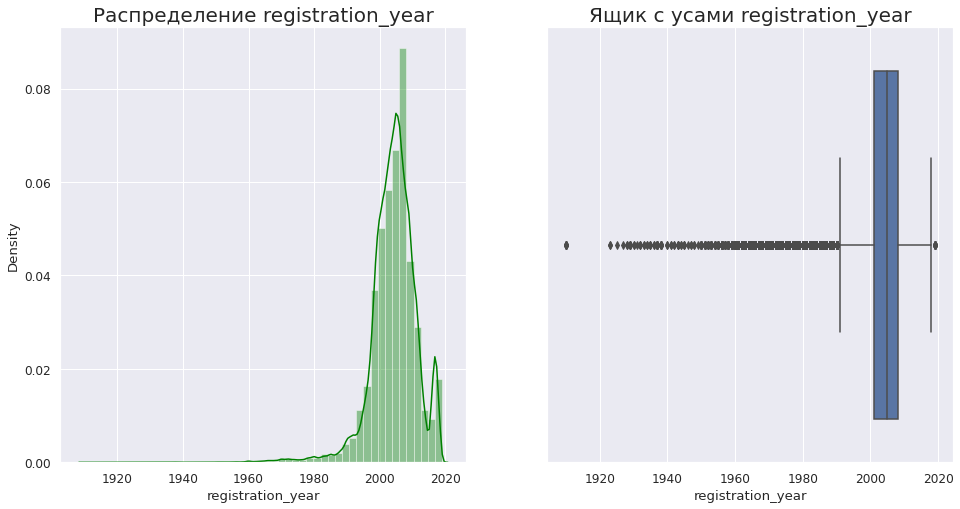

In [27]:
hist_box(auto_df, 'registration_year')

После изучения графиков, видим что максимальный год 2016 c корректировкой на последний год публикации а минимальный год, целесобразно для нашего исследования взять 1980 год. Во-первых все что старше единичные выбросы, во-вторых старше 1980 уже антиквариат.   

In [28]:
auto_df = auto_df.query('registration_year >= 1980 and registration_year <= 2016')

Исследуем признак power.

Из источников известно, что минимальная мощьность автомобиля 13 л/с, а максимальная 1600 л/с, при этом на российском рынке не было в продаже мощнее 650 л/с. Поэтому оставим от 13 до 650 л\с.

In [29]:
auto_df = auto_df.query('power >= 13 and power <= 650')

count    235677.000000
mean        129.072230
std          54.257379
min          13.000000
25%          90.000000
50%         120.000000
75%         155.000000
max         650.000000
Name: power, dtype: float64


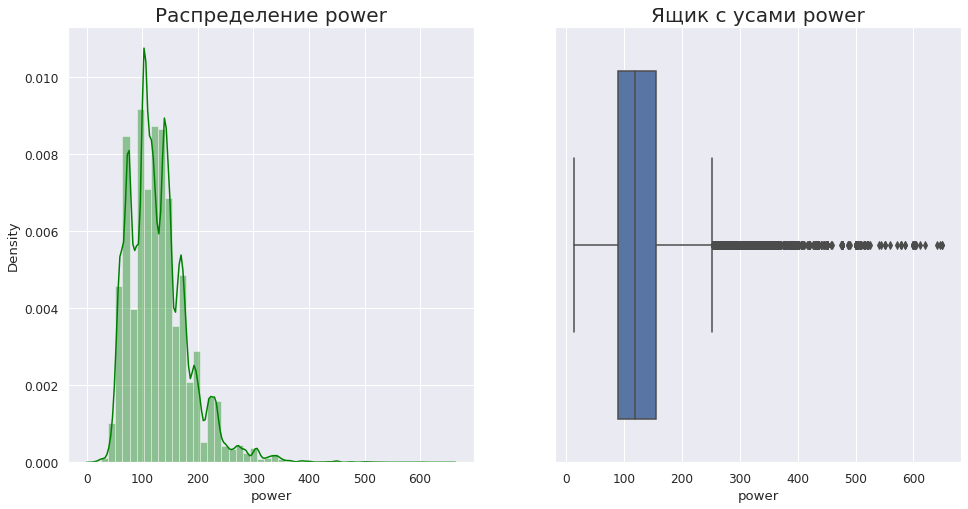

In [30]:
hist_box(auto_df, 'power')

In [31]:
interval_cols = ['price', 'power']

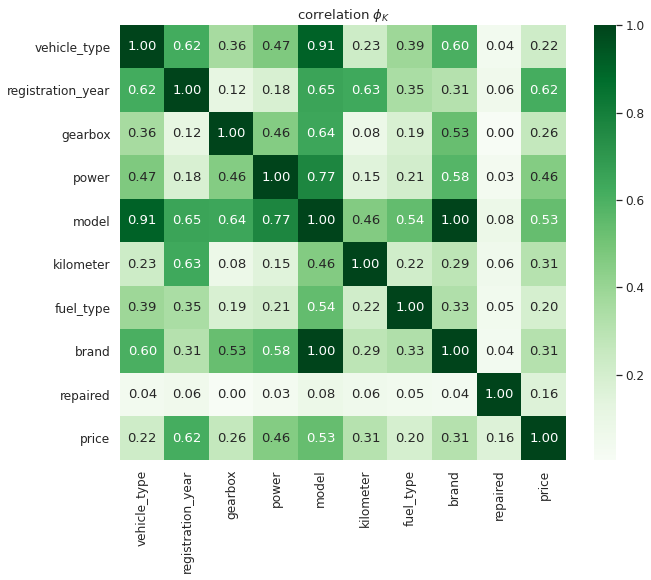

In [32]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(auto_df.phik_matrix(interval_cols = interval_cols),
            annot = True,
            fmt = '.2f',
            cmap='Greens',
            ax = axes)
plt.title(r'correlation $\phi_K$')
plt.show()

In [33]:
auto_df = auto_df.drop(['vehicle_type', 'brand'], axis=1)

При предобработке данных мы выполнили следующие действия:
1. Прежде всего выявили важные и необходимые признаки для нашего исследования:

 Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова - ВАЖЕН
- RegistrationYear — год регистрации автомобиля - ВАЖЕН
- Gearbox — тип коробки передач - ВАЖЕН
- Power — мощность (л. с.) - ВАЖЕН
- Model — модель автомобиля - ВАЖЕН
- Kilometer — пробег (км) - ВАЖЕН
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива - ВАЖЕН
- Brand — марка автомобиля - ВАЖЕН
- Repaired — была машина в ремонте или нет -ВАЖЕН
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

2. Следующим шагом удалили дубликаты и заменили пропущенные значения на unknown , только в колонке 'repaired' пропуски решили присоединить к категории "no" .

3. В  целевом признаке 'price' мы убрали нулевые значение, а также выявили 0,05 перцентиль, для дальнейшей работы. Изучив признак 'price' мы видим, что количество объявлений с нулевой ценой: 8904, мы их удалили так как это явная ошибка к тому же в общем количестве их число незначительно.

4. В признаке registration_year, мы видим что минимальные значения это 1000 год а максимальные 9999 год. Логично будет начать с 1910 года(год появления авто) и до 2024 года.
Но После изучения графиков, видим что максимальный год 2016 и минимальный, целесобразно для нашего исследования взять 1980 год. Во-первых все что старше единичные выбросы, во-вторых старше 1980 уже антиквариат. 

5. Признак power.

Из источников известно, что минимальная мощность автомобиля 13 л/с, а максимальная 1600 л/с, при этом на российском рынке не было в продаже мощнее 650 л/с. Поэтому оставим от 13 до 650 л\с. 

## Обучение моделей

Выделим числовые и категориальные признаки:

In [34]:
auto_df = auto_df.drop_duplicates()


Делим на выборки:

In [35]:
X = auto_df.drop('price', axis=1)
y = auto_df['price']

In [36]:
num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.select_dtypes(exclude='number').columns.tolist()

print(num_col)
print(cat_col)

['registration_year', 'power', 'kilometer']
['gearbox', 'model', 'fuel_type', 'repaired']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)
ohe_columns = ['model', 'gearbox', 'repaired','fuel_type']
num_columns = num_col

In [60]:
ohe_pipe = Pipeline(
    [(
        'simpleImputer_ohe',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ohe',
         OneHotEncoder(
             drop='first',
             handle_unknown='ignore',
             sparse=False
         )
     )
    ]
)

In [39]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        #('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [40]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

LinearRegression

In [41]:
param_grid = [
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],  
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [42]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [43]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['model',
                                       

In [45]:
bm = []
bm.append(randomized_search)

 LightGBM

In [46]:
X_train[cat_col] = X_train[cat_col].astype('category')
X_test[cat_col] = X_test[cat_col].astype('category')

In [47]:
lgbm_model = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

In [48]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 1],  
    'max_depth': [1, 2, 6]
}

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=5
)

random_search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='root_mean_squared_error',
                                           random_state=42, verbose=-1),
                   n_iter=5,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5, 1],
                                        'max_depth': [1, 2, 6]},
                   scoring='neg_root_mean_squared_error')

In [49]:
bm.append(random_search_lgbm)

CatBoost

In [50]:
catboost_model = CatBoostRegressor(verbose=100,
                                   cat_features=cat_col,
                                   random_state=RANDOM_STATE)

In [51]:
param_grid = {
    'depth': [1, 5],
    'learning_rate': [0.1, 0.3]
}

random_search_catboost = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=3
)

random_search_catboost.fit(X_train, y_train)

0:	learn: 3852.0695752	total: 141ms	remaining: 2m 21s
100:	learn: 1855.7661661	total: 6.36s	remaining: 56.7s
200:	learn: 1801.8015527	total: 12.2s	remaining: 48.5s
300:	learn: 1772.8721766	total: 18.4s	remaining: 42.7s
400:	learn: 1750.4628000	total: 24.5s	remaining: 36.6s
500:	learn: 1731.9423025	total: 30.4s	remaining: 30.3s
600:	learn: 1717.5003051	total: 36.5s	remaining: 24.2s
700:	learn: 1705.1662878	total: 42.6s	remaining: 18.2s
800:	learn: 1694.9687163	total: 48.5s	remaining: 12.1s
900:	learn: 1683.8565921	total: 54.5s	remaining: 5.99s
999:	learn: 1675.8106802	total: 1m	remaining: 0us
0:	learn: 3861.3576147	total: 84.5ms	remaining: 1m 24s
100:	learn: 1860.5348294	total: 5.97s	remaining: 53.2s
200:	learn: 1804.4291823	total: 11.8s	remaining: 46.8s
300:	learn: 1773.2303342	total: 17.6s	remaining: 40.9s
400:	learn: 1751.9699690	total: 23.5s	remaining: 35s
500:	learn: 1734.5366503	total: 29.5s	remaining: 29.4s
600:	learn: 1720.0728588	total: 35.6s	remaining: 23.6s
700:	learn: 1708.6

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f6da68cfee0>,
                   n_iter=3,
                   param_distributions={'depth': [1, 5],
                                        'learning_rate': [0.1, 0.3]},
                   scoring='neg_root_mean_squared_error')

In [52]:
bm.append(random_search_catboost)

## Анализ моделей

Создадим список для результатов работы

In [53]:
RMSE = []
model_time_ln_list = []
model_time_pr_list = []

In [54]:
for r in bm:
    RMSE.append(-r.best_score_)
    model = r.best_estimator_
    start_ln = time()
    model.fit(X_train, y_train)
    end_ln = time()
    model_time_ln = (end_ln - start_ln) / 60
    model_time_ln_list.append(model_time_ln)
    start_pr = time()
    model.predict(X_train)
    end_pr = time()
    model_time_pr = (end_pr - start_pr) / 60
    model_time_pr_list.append(model_time_pr) 

0:	learn: 3860.4456868	total: 91.9ms	remaining: 1m 31s
100:	learn: 1860.3589887	total: 7.59s	remaining: 1m 7s
200:	learn: 1803.0074492	total: 14.8s	remaining: 58.7s
300:	learn: 1773.5523364	total: 22.2s	remaining: 51.5s
400:	learn: 1754.4431623	total: 29.5s	remaining: 44s
500:	learn: 1735.7509568	total: 36.7s	remaining: 36.6s
600:	learn: 1721.0891280	total: 44s	remaining: 29.2s
700:	learn: 1709.7966691	total: 51.3s	remaining: 21.9s
800:	learn: 1698.6378045	total: 58.9s	remaining: 14.6s
900:	learn: 1690.9234453	total: 1m 5s	remaining: 7.24s
999:	learn: 1683.0187976	total: 1m 13s	remaining: 0us


In [55]:
models_data = pd.DataFrame(
    {'model_name':['LinearRegression', 'LightGBM', 'CatBoost'],
     'RMSE': RMSE,
     'model_learning_time': model_time_ln_list,
     'model_predict_time': model_time_pr_list,
     
    }
)
models_data

,model_name,RMSE,model_learning_time,model_predict_time
0,LinearRegression,NaN,0.143171,0.013283
1,LightGBM,1775.422665,0.065040,0.025191
2,CatBoost,1778.153086,1.238581,0.015146


**Выводы**

Мы обучили модели Линейной регрессии, LGBMRegressor, CatBoostRegressor, видим что модель LightGBM является лучшей и дает следующие результаты:
- 0.065 время обучения;
- 0.025 минуты время предсказания;
- RMSE 1775,42 

Оценим лучшую модель на тестовой выборке:

In [56]:
model_lgbm = random_search_lgbm.best_estimator_

In [57]:
start_test = time() #замеряем время предсказания
RMSE_test = mean_squared_error(y_test, model_lgbm.predict(X_test), squared = False)
end_test = time()
model_time_test = (end_test - start_test) / 60 
print('RMSE на тестовой выборке: ', RMSE_test)
print('Время предсказания на тестовой выборке: ', model_time_test)

RMSE на тестовой выборке:  1791.9668253635948
Время предсказания на тестовой выборке:  0.008131778240203858


На тестовой выборке:
- RMSE - 1791.96
- Время предсказания -  0.0081

Что соответствует условию.